## Problem description

The assignment for the first week is the first part of the [PyTorch Autograd Onboarding Lab](https://github.com/pytorch/pytorch/wiki/Autograd-Onboarding-Lab).

We're given a function composed of a few PyTorch function calls, and we have to derive a gradient formula for it:

```python
def attn(q, k, v):
    x = torch.matmul(q, k.transpose(0, 1))
    a = torch.tanh(x)
    o = torch.matmul(a, v)
    return o, a
```

## Mario's guidance on solving this


> A bit of background more on the Onboarding exercise and some words for you to look up on the internet:
>
> Start by trying to compute the gradients for the matrix multiplication of two matrices `X = QK^T`, with `Q` and `K` of size (2, 3) .
>
> What this means is that, given `gX` (a gradient of `X`) of the same shape as X, you should try to compute the gradient wrt. `Q` and wrt. `K`.
>
> The way to do this is to compute the vector-Jacobian product (aka vjp). To do this, you need to compute the Jacobian matrix of the transformation `Q -> QK^T`. This map takes a matrix of shape `(2, 3)` (i.e. of 6 elements) and transforms it into a matrix of shape `(2, 2)` (4 elements). As such, it can be thought as a map from R^6 to R^4.
>
> You can then compute the Jacobian `J` of this map, which will be a matrix of shape `(4, 6)`. Then, given the gradient `gX` of shape `(2, 2)` (i.e. of 4 elements), you can flatten it, and compute the vector-Jacobian product, that is, `flatten(gX)*J`. This will give you a vector of size 6. You finally unflatten this vector and that will be the gradient `gQ` of `Q` wrt.  `X` (!!)
>
> This is certainly a mouthful, but if you do not remember the definition of a Jacobian and so on, you can always go to Wikipedia and look at it there.
>
> After doing the above, you should have a formula coordinate-by-coordinate of the values of `gQ` in terms of those of `K` and those of `gX`. Something you should think then is "how can I write this in a simple way, without referring to the coordiantes?".
>
> When you have a concise formula for the above, you can try to do the same thing with `X` wrt `K`.
Then, you can continue doing the same thing with the other parts of the equation, but actually, starting from the bottom to the top as gradients "flow backwards" (even if we do not have a clear understanding of why yet): we start with the gradient of the output and we work our way up to compute the gradients of the intermediary  values, and finish by computing the gradients wrt. the inputs

[Wikipedia - Jacobian matrix and determinant](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)



## Deriving the matrix multiply gradient

So we have two matrices `Q` and `K`, both of size `(2, 3)`:

```python
Q = [[q0, q1, q2],
     [q3, q4, q5]]

K = [[k0, k1, k2],
     [k3, k4, k5]]
```

Transpose `K` to get:

```python
K^T = [[k0, k3],
       [k1, k4],
       [k2, k5]]
```

The result of the matrix multiply is:

```python
X = QK^T
X = [[x0, x1],
     [x2, x3]]
X = [[(q0*k0 + q1*k1 + q2*k2), (q0*k3 + q1*k4 + q2*k5)],
     [(q3*k0 + q4*k1 + q5*k2), (q3*k3 + q4*k4 + q5*k5)]]

```

For calculating the gradient, we are given `gX`, which is the same shape as `X`:

```python
gX = [[gx0, gx1],
      [gx2, gx3]]
```

First, let's find `gQ`, which will be the same size as `Q`. The Jacobian matrix is supposed to be `(4, 6)`. I'll use the definition of the Jacobian matrix from the Wikipedia article. In particular, this one:

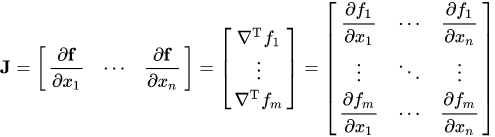

We get this:

```python
J_Q = [[∂x0/∂q0, ∂x0/∂q1, ∂x0/∂q2, ∂x0/∂q3, ∂x0/∂q4, ∂x0/∂q5],
       [∂x1/∂q0, ∂x1/∂q1, ∂x1/∂q2, ∂x1/∂q3, ∂x1/∂q4, ∂x1/∂q5],
       [∂x2/∂q0, ∂x2/∂q1, ∂x2/∂q2, ∂x2/∂q3, ∂x2/∂q4, ∂x2/∂q5],
       [∂x3/∂q0, ∂x3/∂q1, ∂x3/∂q2, ∂x3/∂q3, ∂x3/∂q4, ∂x3/∂q5],
```

Calculating those partial derivatives and plugging them in, we get:

```python
J_Q = [[k0, k1, k2,  0,  0,  0],
       [k3, k4, k5,  0,  0,  0],
       [ 0,  0,  0, k0, k1, k2],
       [ 0,  0,  0, k3, k4, k5]]
```

Now we calculate the vector-Jacobian product:

```python
flatten(gX) = [gx0, gx1, gx2, gx3]

vjp_Q = flatten(gX) * J_Q
vjp_Q = [gx0*k0 + gx1*k3,
         gx0*k1 + gx1*k4,
         gx0*k2 + gx1*k5,
         gx2*k0 + gx3*k3,
         gx2*k1 + gx3*k4,
         gx2*k2 + gx3*k5]
```

Finally, we get `gQ` by unflattening to match the shape of `Q`, (2, 3):

```python
gQ = [[(gx0*k0 + gx1*k3), (gx0*k1 + gx1*k4), (gx0*k2 + gx1*k5)],
      [(gx2*k0 + gx3*k3), (gx2*k1 + gx3*k4), (gx2*k2 + gx3*k5)]]
```

So we can see that the result of `gQ` is actually just some operation between `gX` and `Q`. I'll copy `gX` and `K` here to make it easier to see a pattern.

```python
gX = [[gx0, gx1],
      [gx2, gx3]]

K = [[k0, k1, k2],
     [k3, k4, k5]]
```

Okay, easy! This is just a matrix multiplication, `gQ = matmul(gX, K)`.

## Implementing the matrix multiply gradient

We are given some boilerplate code plug our solution into. It contains code to test it for correctness.

```python
import torch

class Attn(torch.autograd.Function):
    # Start with matmul
    @staticmethod
    def forward(ctx, q, k):
        x = torch.matmul(q, k.transpose(0, 1))
        ctx.save_for_backward(...)
        return x

    # Go for the kill
    # @staticmethod
    # def forward(ctx, q, k, v):
    #     x = torch.matmul(q, k.transpose(0, 1))
    #     a = torch.tanh(x)
    #     o = torch.matmul(a, v)
    #     ctx.save_for_backward(...)
    #     return o, a

    @staticmethod
    def backward(ctx, gx):
        q, k, ... = ctx.saved_tensors
        ...
        return gq, gk

q = torch.rand(2, 3, dtype=torch.float64, requires_grad=True)
k = torch.rand(2, 3, dtype=torch.float64, requires_grad=True)
v = torch.rand(2, 4, dtype=torch.float64, requires_grad=True)
attn = Attn.apply

torch.autograd.gradcheck(attn, (q, k, v), atol=0.01)
```

So I plugged my backward formula for `gQ` into this code and removed all the extra stuff I don't need yet.

After I verified that the `gQ` formula worked, I also figured out the formula for `gK`. I didn't actually go through the calculations I did for `gQ`. I figured that the two formulas would have to be almost the same as each other. But for the `gK` formula, I thought that `Q` would have to be transposed since `K` is transposed in the forward function. Then, I figured that we would have to matrix multiply with `gX`, since we did that for `gQ`. I saw that the only ordering that works is `matmul(Q^T, gX)`, since the sizes wouldn't match up correctly if I did `matmul(gX, Q^T)`. You can't multiply a 2x2 matrix by a 3x2 matrix, but you can multiply a 3x2 matrix by a 2x2 matrix. The output of the multiply is 3x2, but I needed 2x3, so I figured I'd just transpose it and see if it works. And it did! The final formula is `gK = matmul(Q^T, gX)^T`. It would also be possible to go through the whole Jacobian-vector product calculation to get there, but why bother if you can avoid it?

In [1]:
import torch

class Attn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Q, K):
        X = torch.matmul(Q, K.transpose(0, 1))
        ctx.save_for_backward(Q, K)
        return X

    @staticmethod
    def backward(ctx, gX):
        Q, K = ctx.saved_tensors
        
        gQ = torch.matmul(gX, K)
        gK = torch.matmul(Q.t(), gX).t()
        
        return gQ, gK

Q = torch.rand(2, 3, dtype=torch.float64, requires_grad=True)
K = torch.rand(2, 3, dtype=torch.float64, requires_grad=True)
attn = Attn.apply

torch.autograd.gradcheck(attn, (Q, K), atol=0.01)

/home/endoplasm/miniconda3/envs/main/lib/python3.9/site-packages/torch/autograd/__init__.py:234: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(


True

## Deriving the `tanh` gradient

The next part of the assignment is to compute the gradient for the operation `A = tanh(X)`. Recall that in our example above, `X` has the shape `(2, 2)`. Since `tanh` is a pointwise operation, the output will also be `(2, 2)`. We will assume that we're given a gradient for the output `gA` of shape equal to that of `A`, and we have to calculuate `gX`.

```python
X = [[x0, x1],
     [x2, x3]]

A = [[a0, a1],
     [a2, a3]]
A = [[tanh(x0), tanh(x1)],
     [tanh(x2), tanh(x3)]]

J_X = [[∂a0/∂x0, ∂a0/∂x1, ∂a0/∂x2, ∂a0/∂x3],
       [∂a1/∂x0, ∂a1/∂x1, ∂a1/∂x2, ∂a1/∂x3],
       [∂a2/∂x0, ∂a2/∂x1, ∂a2/∂x2, ∂a2/∂x3],
       [∂a3/∂x0, ∂a3/∂x1, ∂a3/∂x2, ∂a3/∂x3]]
```

To calculate these partial derivatives, we'll have to use the fact that for a scalar `x`,

```python
d (tanh(x)) / dx = 1 - tanh(x)^2
```

Substituting all the partial derivatives in `J_X`:

```python
J_X = [[1-tanh(x0)^2,            0,            0,            0],
       [           0, 1-tanh(x1)^2,            0,            0],
       [           0,            0, 1-tanh(x2)^2,            0],
       [           0,            0,            0, 1-tanh(x3)^2]]
```

Now we can calculate the Jacobian-vector product between `flatten(gA)` and `J_X`:

```python
flatten(gA) = [ga0, ga1, ga2, ga3]
vjp_X = flatten(gA) * J_X
vjp_X = [
    ga0 * (1 - tanh(x0)^2),
    ga1 * (1 - tanh(x1)^2),
    ga2 * (1 - tanh(x2)^2),
    ga3 * (1 - tanh(x3)^2)]
```

Then we reshape this to the shape of `X`, `(2, 2)`, to get `gX`:

```python
gX = [[ga0 * (1 - tanh(x0)^2), ga1 * (1 - tanh(x1)^2)],
      [ga2 * (1 - tanh(x2)^2), ga3 * (1 - tanh(x3)^2)]]
```

We can see that this is actually the same as `gX = gA * (1 - tanh(X)^2)`

Let's verify it.

In [2]:
import torch

class Attn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X):
        A = torch.tanh(X)
        ctx.save_for_backward(X)
        return A

    @staticmethod
    def backward(ctx, gA):
        (X,) = ctx.saved_tensors
        
        gX = gA * (1 - torch.tanh(X)**2)
        
        return gX

X = torch.rand(2, 2, dtype=torch.float64, requires_grad=True)
attn = Attn.apply

torch.autograd.gradcheck(attn, (X,), atol=0.01)

True

## Another matmul

The last operation is `O = matmul(A, V)`. This is slightly different than the matmul gradient we calculated before, since `V` is not transposed.

If `A` is shape `(2, 2)` and `V` is shape `(2, 4)` then `O` will be `(2, 4)`. We're given `gO`, which will be `(2, 4)` in this example.

Of course, we can reuse our previous work for this example. Remember that we showed earlier that `gQ = matmul(gX, K)` and `gK = matmul(Q^T, gX)^T` for the operation `X = matmul(Q, K^T)`. We can perform some substitutions here, `X --> O`, `Q --> A`, and `K^T --> V`.

```python
gQ = matmul(gX, K)
gK = matmul(Q^T, gX)^T
```

After substitution:

```python
gA = matmul(gO, V^T)

gV^T = matmul(A^T, gO)^T
gV = matmul(A^T, gO)

```

And now let's test the formulae for `gA` and `gV`.

In [3]:
import torch

class Attn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A, V):
        O = torch.matmul(A, V)
        ctx.save_for_backward(A, V)
        return O

    @staticmethod
    def backward(ctx, gO):
        A, V = ctx.saved_tensors
        
        gA = torch.matmul(gO, V.t())
        gV = torch.matmul(A.t(), gO)
        
        return gA, gV

A = torch.rand(2, 2, dtype=torch.float64, requires_grad=True)
V = torch.rand(2, 4, dtype=torch.float64, requires_grad=True)
attn = Attn.apply

torch.autograd.gradcheck(attn, (A, V), atol=0.01)

True

## Combining everything

Now we have to combine all of gradient formulae into one. Since gradient calculations flow backwards, we'll put them in the opposite order of how they appear in the forward function. Here's the forward again:

```python
X = matmul(Q, Q^T)
A = tanh(X)
O = matmul(A, V)
return O, A
```

Here's how we'll lay out the backward function:

```python
# Gradients for second matrix multiply `O = matmul(A, V)`:
gA = ...
gV = ...

# Gradient for `A = tanh(X)`
gX = ...

# Gradients for first matrix multiply `X = matmul(Q, Q^T)`:
gQ = ...
gK = ...
```

Remember, we're returning both `O` and `A` from the forward function, so the backward function will receive `gO` and `gA` as arguments. This seems kind of odd--we'll receive a `gA`, but we also have to calculate a `gA` for the second matrix multiply from the forward function. So we have two different gradients for `A`. What are we supposed to do with them?

To answer that question, let's imagine a more general case. Let's imagine we have the following forward function:

```python
Z = f0(Y)
W = f1(Y)
return Z, W
```

Here, `f0` and `f1` are arbitrary operations. `Y` is the input and `Z` and `W` are the outputs of the forward function. We'll be given `gZ` and `gW` for the backward formula, and we'll need to calculate `gY`. Here's the layout of the backward function:

```python
gY1 = f1_backward(gW, Y)
gY0 = f0_backward(gZ, Y)
gY = ???
```

Since we used `Y` as the input to two different operations that have their own separate differentiable outputs, we have to calculate two different gradients for `Y`, `gY0` and `gY1` above. Then we have to combine them somehow to get the full gradient `gY`. How do we combine them?

Well, let's think about what happens if we change `gW` a little bit. `gY1` will change a little bit and `gY0` will remain unchanged. `gY` needs to change a little bit as well, and the amount that it changes by has to be equal to the amount that `gY1` changed.

On the other hand, if we changed `gZ` a little bit, `gY0` would have to change a little bit, `gY1` would stay unchanged, and `gY` will change by the same amount that `gY0` changed by.

So `gY` needs to be exactly proportional to both `gY0` and `gY1`. So it turns out that the answer is to just add `gY0` and `gY1` together to get `gY`. (I don't know a more rigorous explanation than this. It would be good to find an article that explains it and link it here.)

```python
gY = gY0 + gY1
```

Using the same logic for the backward formula for our activation function, we'll just add together our two different gradients for `A` and use the result for the `gX` formula. Now let's put everything together:

```python
# Given gO and gA

# Gradients for second matrix multiply `O = matmul(A, V)`:
gA_combined = gA + matmul(gO, V^T)
gV = matmul(A^T, gO)

# Gradient for `A = tanh(X)`
gX = gA_combined * (1 - tanh(x)^2)

# Gradients for first matrix multiply `X = matmul(Q, Q^T)`:
gQ = matmul(gX, K)
gK = matmul(Q^T, gX)^T
```

In [4]:
import torch

class Attn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Q, K, V):
        X = torch.matmul(Q, K.transpose(0, 1))
        A = torch.tanh(X)
        O = torch.matmul(A, V)
        
        ctx.save_for_backward(Q, K, V, X, A)
        return O, A

    @staticmethod
    def backward(ctx, gO, gA):
        Q, K, V, X, A = ctx.saved_tensors

        gA_combined = gA + torch.matmul(gO, V.t())
        gV = torch.matmul(A.t(), gO)
        gX = gA_combined * (1 - torch.tanh(X)**2)
        gQ = torch.matmul(gX, K)
        gK = torch.matmul(Q.t(), gX).t()
        
        return gQ, gK, gV

Q = torch.rand(2, 3, dtype=torch.float64, requires_grad=True)
K = torch.rand(2, 3, dtype=torch.float64, requires_grad=True)
V = torch.rand(2, 4, dtype=torch.float64, requires_grad=True)
attn = Attn.apply

torch.autograd.gradcheck(attn, (Q, K, V), atol=0.01)

True

And that's it!